In [6]:
from ase.io.trajectory import TrajectoryReader as tr

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from publish_format import useLargeSize

In [7]:
color = {"DFT": "k",
         "AMPtorch DFT\n(with force)": "tab:orange",
         "AMPtorch DFT\n(without force)": "tab:blue",
         "AMPtorch DMC": "tab:red",}

In [3]:
def extract_forces(filename):
    forces = []
    trajs = tr(filename)
    for traj in trajs:
        forces.append(np.linalg.norm(np.array(traj.get_forces())))
    return np.array(forces)

def extract_geom(filename):
    '''
    "O H H"
    '''
    d_o_h1 = []
    d_o_h2 = []
    theta_h1_o_h2 = []
    
    trajs = tr(filename)
    for traj in trajs:
        d_o_h1.append(traj.get_distance(0, 1))
        d_o_h2.append(traj.get_distance(0, 2))
        theta_h1_o_h2.append(traj.get_angle(1,0,2))
      
    data = pd.DataFrame(
        {r"$d_{O-H_{1}}$": d_o_h1, 
         r"$d_{O-H_{2}}$": d_o_h2, 
         r"$\theta_{H_{1}-O-H_{2}}$": theta_h1_o_h2,
         }
    )
    return data

## NVT results analysis

Define the corresponding NVT trajectories

In [14]:
file = {}

file["DFT"] = "../md/nvt/dft/md_nvt_dft.traj"
file["AMPtorch DFT\n(with force)"] = "../md/nvt/amptorch_dft_force/md_nvt_amptorch_test.traj"
file["AMPtorch DFT\n(without force)"] = "../md/nvt/amptorch_dft_noforce/md_nvt_amptorch_test.traj"
file["AMPtorch DMC"] = "../md/nvt/amptorch_dmc/md_nvt_amptorch_test.traj"

In [15]:
# show the running time for each trajectories
for item in file:
    print(item, " has length ", len(tr(file[item])))

DFT  has length  2001
AMPtorch DFT
(with force)  has length  2001
AMPtorch DFT
(without force)  has length  2001
AMPtorch DMC  has length  2001


Check starting structure

In [16]:
for item in file:
    print(item)
    print(tr(file[item])[0
    ].get_positions())

DFT
[[7.49737892 7.5500009  7.90509902]
 [6.72926106 7.54999957 7.29828622]
 [8.2707709  7.54999953 7.30501418]]
AMPtorch DFT
(with force)
[[7.49737892 7.5500009  7.90509902]
 [6.72926106 7.54999957 7.29828622]
 [8.2707709  7.54999953 7.30501418]]
AMPtorch DFT
(without force)
[[7.49737892 7.5500009  7.90509902]
 [6.72926106 7.54999957 7.29828622]
 [8.2707709  7.54999953 7.30501418]]
AMPtorch DMC
[[7.49737892 7.5500009  7.90509902]
 [6.72926106 7.54999957 7.29828622]
 [8.2707709  7.54999953 7.30501418]]


### Extract mean values for the observables

In [17]:
for item in file:
    geom = extract_geom(file[item])
    print(item)
    print(geom.mean())

DFT
$d_{O-H_{1}}$                 0.969479
$d_{O-H_{2}}$                 0.970836
$\theta_{H_{1}-O-H_{2}}$    104.439200
dtype: float64
AMPtorch DFT
(with force)
$d_{O-H_{1}}$                 0.962856
$d_{O-H_{2}}$                 0.964317
$\theta_{H_{1}-O-H_{2}}$    106.429879
dtype: float64
AMPtorch DFT
(without force)
$d_{O-H_{1}}$                 0.956137
$d_{O-H_{2}}$                 0.958424
$\theta_{H_{1}-O-H_{2}}$    102.315871
dtype: float64
AMPtorch DMC
$d_{O-H_{1}}$                 0.892119
$d_{O-H_{2}}$                 0.894226
$\theta_{H_{1}-O-H_{2}}$    103.700896
dtype: float64


### Plot the Energy trajectory

In [18]:
def extract_total_energy(filename):
    energy = []
    trajs = tr(filename)
    for traj in trajs:
        energy.append(traj.get_total_energy())
    return np.array(energy)

tot_e = {}
for item in file:
    tot_e[item] = extract_total_energy(file[item])
    # tot_e[item] -= np.mean(tot_e[item])
    tot_e[item] -= np.min(tot_e[item])

In [19]:
def extract_potential_energy(filename):
    energy = []
    trajs = tr(filename)
    for traj in trajs:
        energy.append(traj.get_potential_energy())
    return np.array(energy)

pot_e = {}
for item in file:
    pot_e[item] = extract_potential_energy(file[item])
    pot_e[item] -= min(pot_e[item])

In [20]:
def extract_kinetic_energy(filename):
    energy = []
    trajs = tr(filename)
    for traj in trajs:
        energy.append(traj.get_kinetic_energy())
    return np.array(energy)

kin_e = {}
for item in file:
    kin_e[item] = extract_kinetic_energy(file[item])

Plot the Etot v.s. time

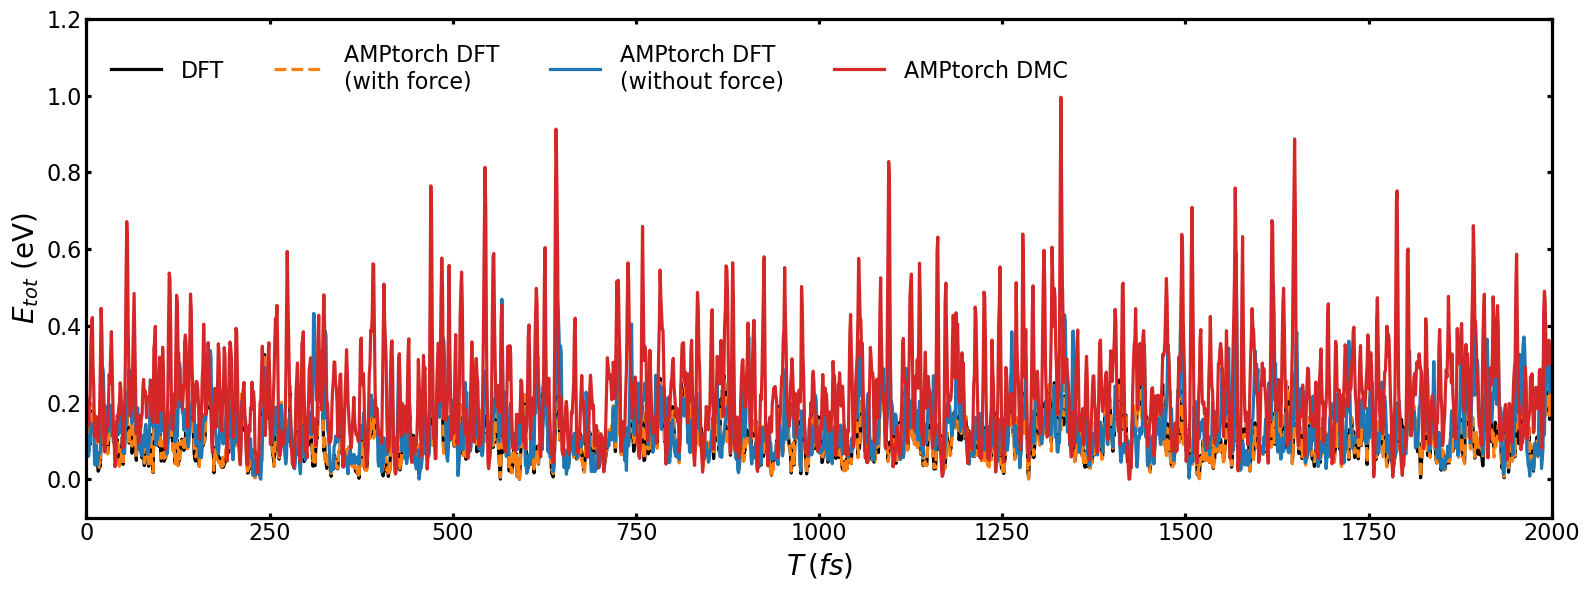

In [41]:
plot_data = tot_e
figname = "h2o_nvt_etot.png"
xlabel = r"$T\,(fs)$"
ylabel = r"$E_{tot}$ (eV)"

plt.style.use('default')
fig, ax = plt.subplots(figsize=(16,6))

# start, end = 0, min(2000, len(plot_data["DFT"]))
start, end = 0, 2000
time = np.arange(end)

for item in plot_data:
    if item == "AMPtorch DFT\n(with force)":
        ax.plot(time, 
                plot_data[item][start:end],
                c=color[item],
                linestyle="dashed",
                label=item)
    else:
        ax.plot(time, 
                plot_data[item][start:end],
                c=color[item],
                label=item)

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.tick_params(axis="y")
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.legend(loc=(0.01, 0.83), frameon=False, fontsize=18, ncol=4)
ax.set_xlim(start, end)
ax.set_ylim(-0.1, 1.2)
useLargeSize(plt, ax)
plt.savefig("./nvt/{}".format(figname), dpi=300)

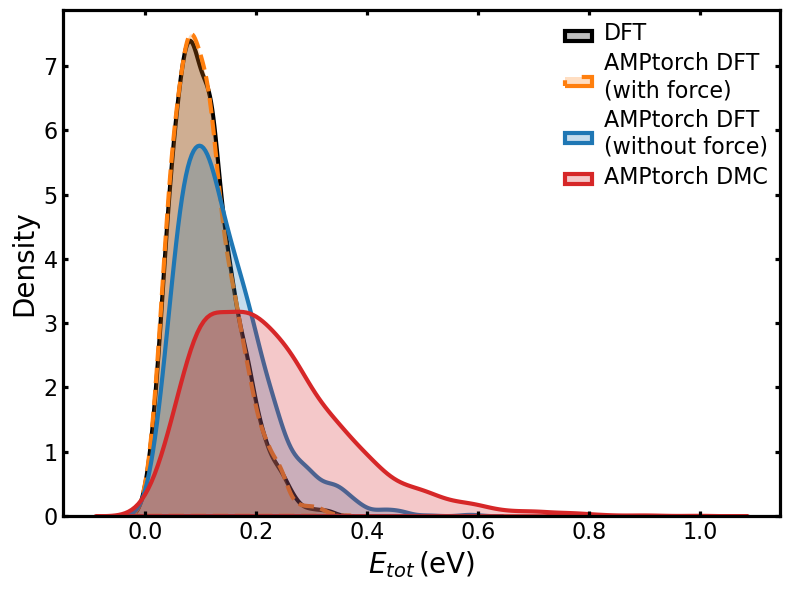

In [33]:
plot_data = tot_e

figname = "h2o_nvt_etot_distribution.png"
xlabel = r"$E_{tot}\,$(eV)"
ylabel = "Density"

plt.style.use('default')
fig, ax = plt.subplots(figsize=(8,6))

for item in plot_data:
    if item == "AMPtorch DFT\n(with force)":
        sns.kdeplot(plot_data[item], 
                    shade = True, 
                    linewidth = 3, 
                    bw_adjust = 1, 
                    linestyle="dashed",
                    label = item, 
                    color = color[item],
                )
    else:
        sns.kdeplot(plot_data[item], 
                    shade = True, 
                    linewidth = 3, 
                    bw_adjust = 1, 
                    label = item, 
                    color = color[item],
                )

ax.set_xlabel(xlabel=xlabel)
ax.set_ylabel(ylabel=ylabel)
ax.tick_params(axis="y")
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.legend(frameon=False)
# ax.set_ylim(0, 4)
useLargeSize(plt, ax)
plt.savefig("./nvt/{}".format(figname), dpi=300)

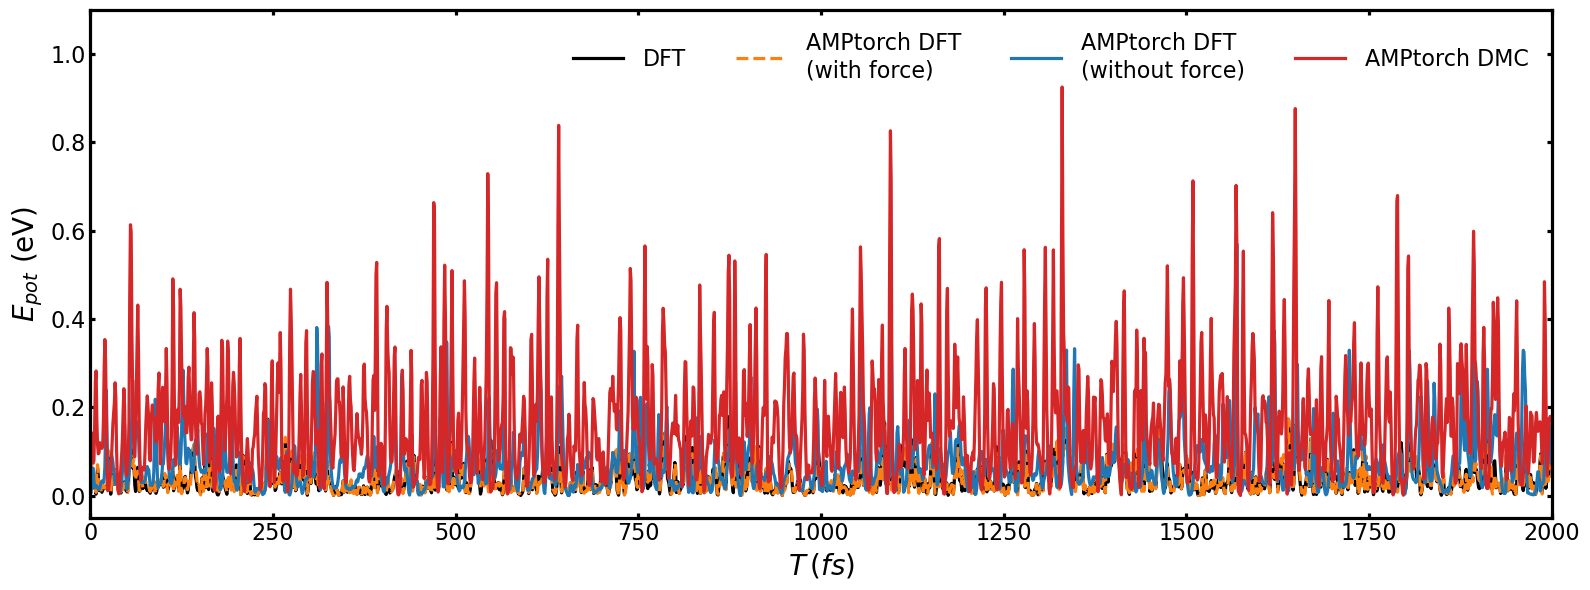

In [40]:
plot_data = pot_e
figname = "h2o_nvt_epot.png"
xlabel = r"$T\,(fs)$"
ylabel = r"$E_{pot}$ (eV)"

plt.style.use('default')
fig, ax = plt.subplots(figsize=(16,6))

start, end = 0, 2000
time = np.arange(end)

for item in plot_data:
    if item == "AMPtorch DFT\n(with force)":
        ax.plot(time, 
                plot_data[item][start:end],
                c=color[item],
                linestyle="dashed",
                label=item)
    else:
        ax.plot(time, 
                plot_data[item][start:end],
                c=color[item],
                label=item)

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.tick_params(axis="y")
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.legend(frameon=False, fontsize=18, ncol=4)
ax.set_xlim(start, end)
ax.set_ylim(-0.05, 1.1)
useLargeSize(plt, ax)
plt.savefig("./nvt/{}".format(figname), dpi=300)

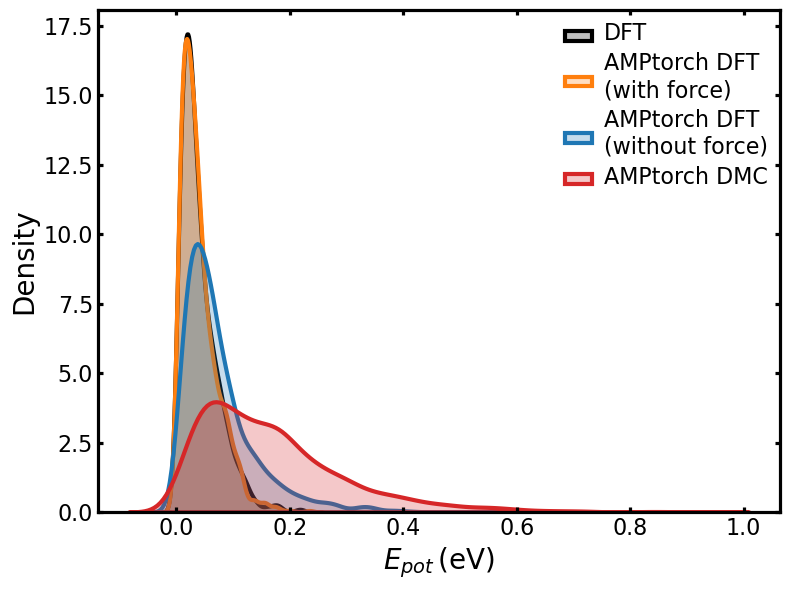

In [43]:
plot_data = pot_e

figname = "h2o_nvt_epot_distribution.png"
xlabel = r"$E_{pot}\,$(eV)"
ylabel = "Density"

plt.style.use('default')
fig, ax = plt.subplots(figsize=(8,6))

for item in plot_data:
    if item == "AMPtorch DFT\n(with force)":
        sns.kdeplot(plot_data[item], 
                    shade = True, 
                    linewidth = 3, 
                    bw_adjust = 1, 
                    # linestyle="dashed",
                    label = item, 
                    color = color[item],
                )
    else:
        sns.kdeplot(plot_data[item], 
                    shade = True, 
                    linewidth = 3, 
                    bw_adjust = 1, 
                    label = item, 
                    color = color[item],
                )

ax.set_xlabel(xlabel=xlabel)
ax.set_ylabel(ylabel=ylabel)
ax.tick_params(axis="y")
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.legend(frameon=False)
# ax.set_ylim(0,7)
useLargeSize(plt, ax)
plt.savefig("./nvt/{}".format(figname), dpi=300)

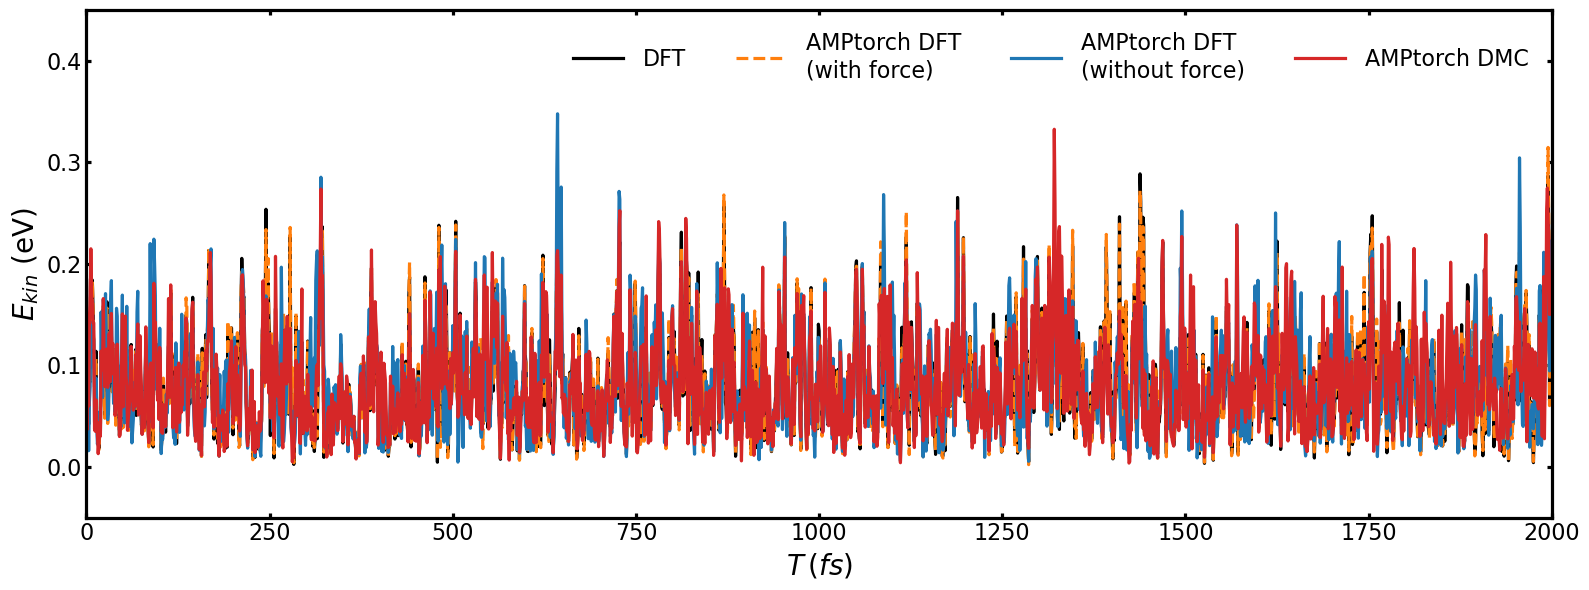

In [45]:
plot_data = kin_e
figname = "h2o_nvt_ekin.png"
xlabel = r"$T\,(fs)$"
ylabel = r"$E_{kin}$ (eV)"

plt.style.use('default')
fig, ax = plt.subplots(figsize=(16,6))

start, end = 0, 2000
time = np.arange(end)

for item in plot_data:
    if item == "AMPtorch DFT\n(with force)":
        ax.plot(time, 
                plot_data[item][start:end],
                c=color[item],
                linestyle="dashed",
                label=item)
    else:
        ax.plot(time, 
                plot_data[item][start:end],
                c=color[item],
                label=item)

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.tick_params(axis="y")
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.legend(frameon=False, fontsize=18, ncol=4)
ax.set_xlim(start, end)
ax.set_ylim(-0.05, 0.45)
useLargeSize(plt, ax)
plt.savefig("./nvt/{}".format(figname), dpi=300)

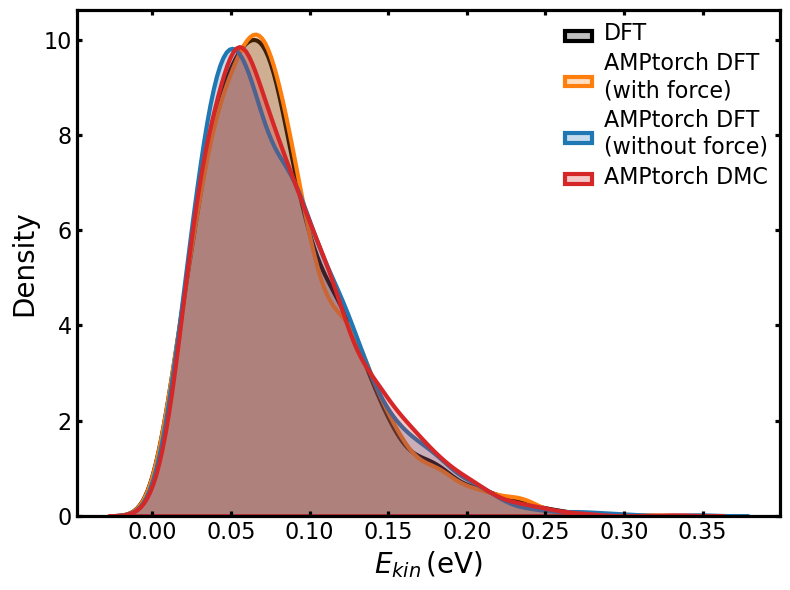

In [47]:
plot_data = kin_e

figname = "h2o_nvt_ekin_distribution.png"
xlabel = r"$E_{kin}\,$(eV)"
ylabel = "Density"

plt.style.use('default')
fig, ax = plt.subplots(figsize=(8,6))

for item in plot_data:
    if item == "AMPtorch DFT\n(with force)":
        sns.kdeplot(plot_data[item], 
                    shade = True, 
                    linewidth = 3, 
                    bw_adjust = 1, 
                    # linestyle="dashed",
                    label = item, 
                    color = color[item],
                )
    else:
        sns.kdeplot(plot_data[item], 
                    shade = True, 
                    linewidth = 3, 
                    bw_adjust = 1, 
                    label = item, 
                    color = color[item],
                )

ax.set_xlabel(xlabel=xlabel)
ax.set_ylabel(ylabel=ylabel)
ax.tick_params(axis="y")
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.legend(frameon=False)
# ax.set_ylim(0,7)
useLargeSize(plt, ax)
plt.savefig("./nvt/{}".format(figname), dpi=300)

#### Plot geometry v.s. time

In [48]:
data = {}

for item in file:
    data[item] = extract_geom(file[item])

Plot $d_{O-H_{1}}$ v.s. time & distribution

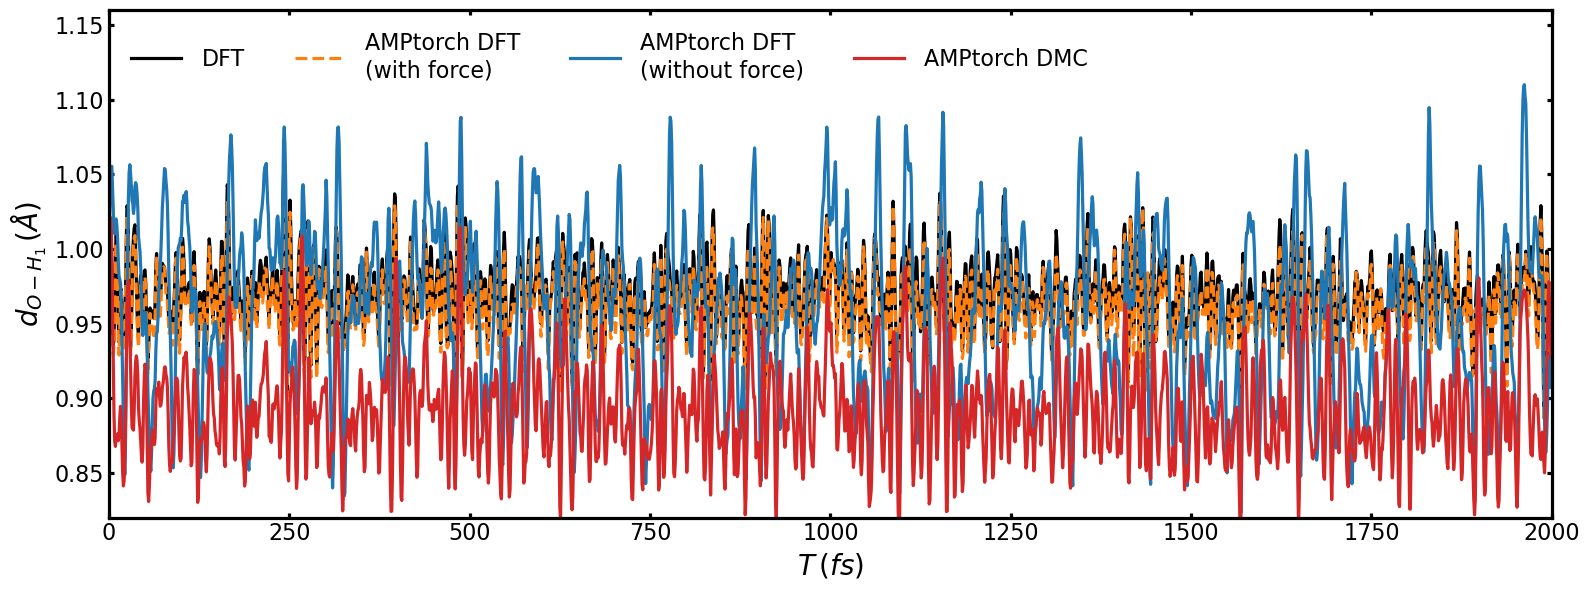

In [49]:
plot_data = {}
for item in file:
    plot_data[item] = data[item][r"$d_{O-H_{1}}$"]

min_len = float("inf")
for item in plot_data:
    min_len = min(min_len, len(plot_data[item]))
# start, end = 0, min(1000, min_len)
start, end = 0, 2000
time = np.arange(end)

figname = "h2o_nvt_oh1_{}.png".format(end)
xlabel = r"$T\,(fs)$"
ylabel = r"$d_{O-H_1}\,({\AA})$"

plt.style.use('default')
fig, ax = plt.subplots(figsize=(16,6))

for item in plot_data:
    if item == "AMPtorch DFT\n(with force)":
        ax.plot(time, 
                plot_data[item][start:end],
                c=color[item],
                linestyle="dashed",
                label=item)
    else:
        ax.plot(time, 
                plot_data[item][start:end],
                c=color[item],
                label=item)

ax.set_xlabel(xlabel=xlabel)
ax.set_ylabel(ylabel=ylabel)
ax.tick_params(axis="y")
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.legend(frameon=False, fontsize=18, ncol=4)
ax.set_xlim(start, end)
ax.set_ylim(0.82, 1.16)
useLargeSize(plt, ax)
plt.savefig("./nvt/{}".format(figname), dpi=300)

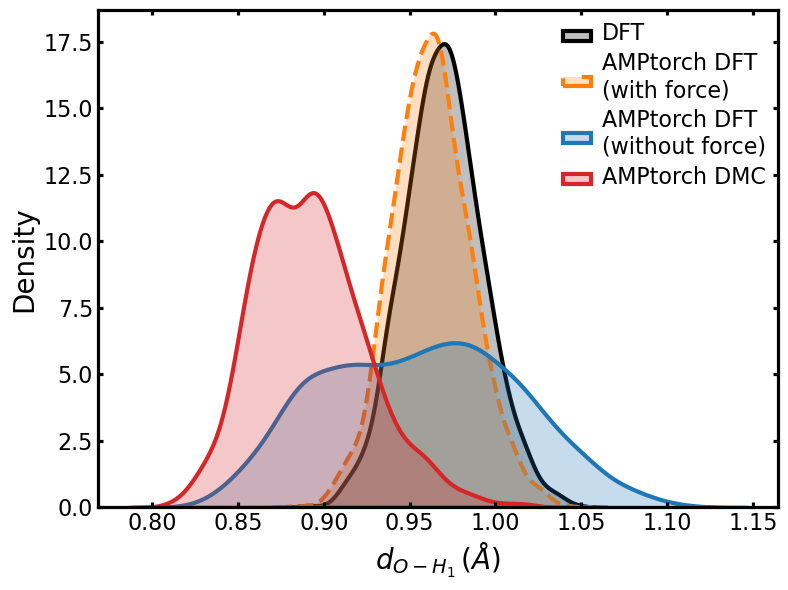

In [50]:
plot_data = {}
for item in file:
    plot_data[item] = data[item][r"$d_{O-H_{1}}$"]

figname = "h2o_nvt_oh1_distribution.png"
xlabel = r"$d_{O-H_1}\,({\AA})$"
ylabel = "Density"

plt.style.use('default')
fig, ax = plt.subplots(figsize=(8,6))

for item in plot_data:
    if item == "AMPtorch DFT\n(with force)":
        sns.kdeplot(plot_data[item], 
                    shade = True, 
                    linewidth = 3, 
                    bw_adjust = 1, 
                    linestyle="dashed",
                    label = item, 
                    color = color[item],
                )
    else:
        sns.kdeplot(plot_data[item], 
                    shade = True, 
                    linewidth = 3, 
                    bw_adjust = 1, 
                    label = item, 
                    color = color[item],
                )

ax.set_xlabel(xlabel=xlabel)
ax.set_ylabel(ylabel=ylabel)
ax.tick_params(axis="y")
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.legend(frameon=False)
useLargeSize(plt, ax)
plt.savefig("./nvt/{}".format(figname), dpi=300)

Plot $d_{O-H_{2}}$ v.s. time

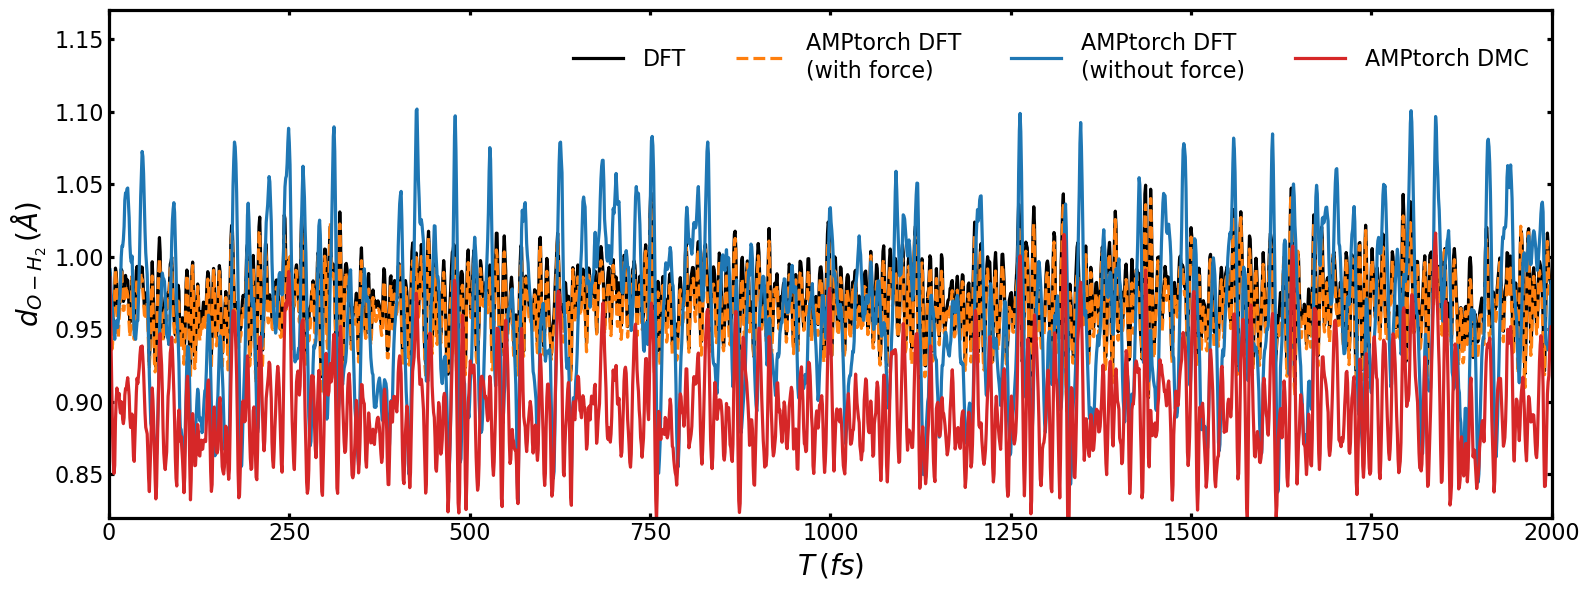

In [51]:
plot_data = {}
for item in file:
    plot_data[item] = data[item][r"$d_{O-H_{2}}$"]

min_len = float("inf")
for item in plot_data:
    min_len = min(min_len, len(plot_data[item]))
# start, end = 0, min(1000, min_len)
start, end = 0, 2000
time = np.arange(end)

figname = "h2o_nvt_oh2_{}.png".format(end)
xlabel = r"$T\,(fs)$"
ylabel = r"$d_{O-H_2}\,({\AA})$"

plt.style.use('default')
fig, ax = plt.subplots(figsize=(16,6))

for item in plot_data:
    if item == "AMPtorch DFT\n(with force)":
        ax.plot(time, 
                plot_data[item][start:end],
                c=color[item],
                linestyle="dashed",
                label=item)
    else:
        ax.plot(time, 
                plot_data[item][start:end],
                c=color[item],
                label=item)
            
ax.set_xlabel(xlabel=xlabel)
ax.set_ylabel(ylabel=ylabel)
ax.tick_params(axis="y")
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.legend(frameon=False, fontsize=18, ncol=4)
ax.set_xlim(start, end)
ax.set_ylim(0.82, 1.17)
useLargeSize(plt, ax)
plt.savefig("./nvt/{}".format(figname), dpi=300)

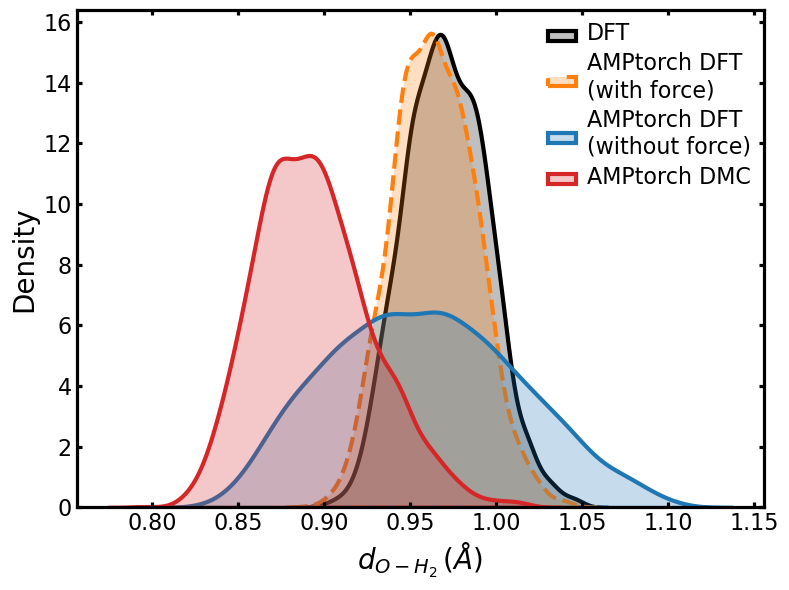

In [52]:
plot_data = {}
for item in file:
    plot_data[item] = data[item][r"$d_{O-H_{2}}$"]

figname = "h2o_nvt_oh2_distribution.png"
xlabel = r"$d_{O-H_2}\,({\AA})$"
ylabel = "Density"

plt.style.use('default')
fig, ax = plt.subplots(figsize=(8,6))

for item in plot_data:
    if item == "AMPtorch DFT\n(with force)":
        sns.kdeplot(plot_data[item], 
                    shade = True, 
                    linewidth = 3, 
                    bw_adjust = 1, 
                    linestyle="dashed",
                    label = item, 
                    color = color[item],
                )
    else:
        sns.kdeplot(plot_data[item], 
                    shade = True, 
                    linewidth = 3, 
                    bw_adjust = 1, 
                    label = item, 
                    color = color[item],
                )

ax.set_xlabel(xlabel=xlabel)
ax.set_ylabel(ylabel=ylabel)
ax.tick_params(axis="y")
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.legend(frameon=False)
useLargeSize(plt, ax)
plt.savefig("./nvt/{}".format(figname), dpi=300)

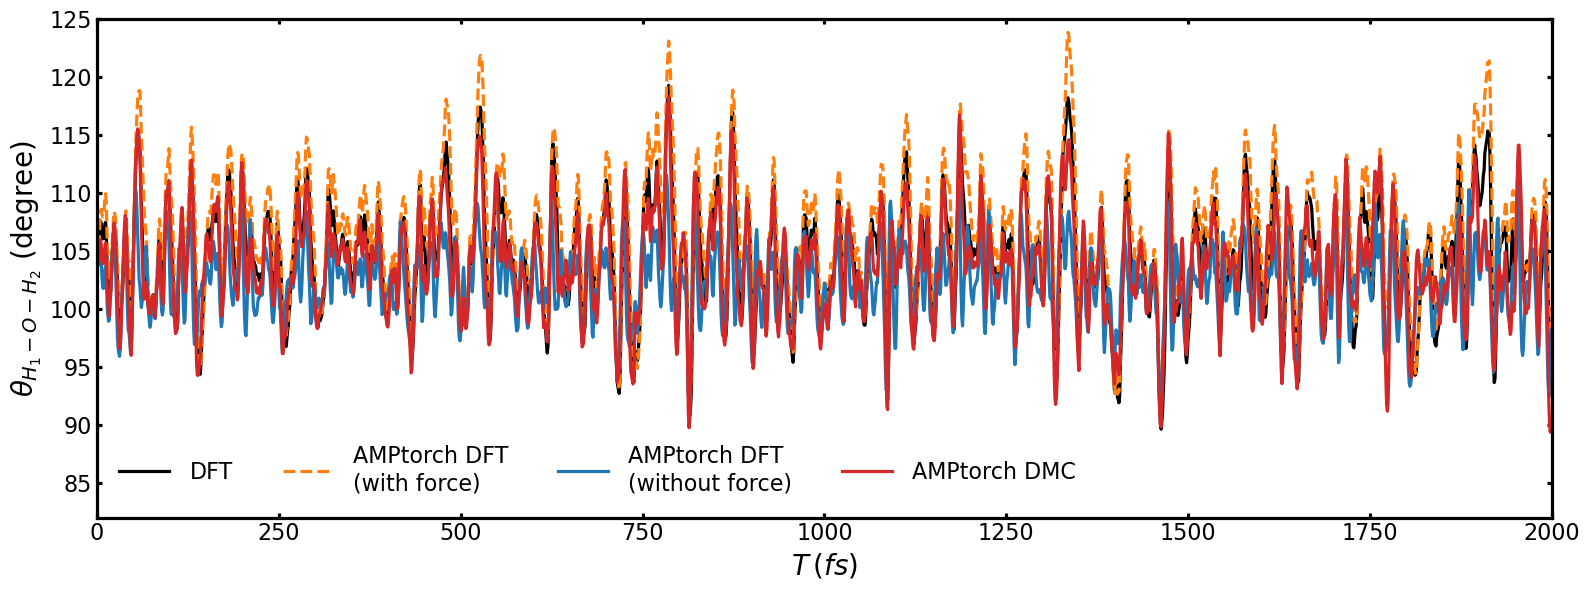

In [56]:
plot_data = {}
for item in file:
    plot_data[item] = data[item][r"$\theta_{H_{1}-O-H_{2}}$"]

min_len = float("inf")
for item in plot_data:
    min_len = min(min_len, len(plot_data[item]))
# start, end = 0, min(1000, min_len)
start, end = 0, 2000
time = np.arange(end)

figname = "h2o_nvt_theta_{}.png".format(end)
xlabel = r"$T\,(fs)$"
ylabel = r"$\theta_{H_{1}-O-H_{2}}$ (degree)"

plt.style.use('default')
fig, ax = plt.subplots(figsize=(16,6))

for item in plot_data:
    if item == "AMPtorch DFT\n(with force)":
        ax.plot(time, 
                plot_data[item][start:end],
                c=color[item],
                linestyle="dashed",
                label=item)
    else:
        ax.plot(time, 
                plot_data[item][start:end],
                c=color[item],
                label=item)
            
ax.set_xlabel(xlabel=xlabel)
ax.set_ylabel(ylabel=ylabel)
ax.tick_params(axis="y")
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.legend(frameon=False, fontsize=18, ncol=4)
ax.set_xlim(start, end)
ax.set_ylim(82, 125)
useLargeSize(plt, ax)
plt.savefig("./nvt/{}".format(figname), dpi=300)

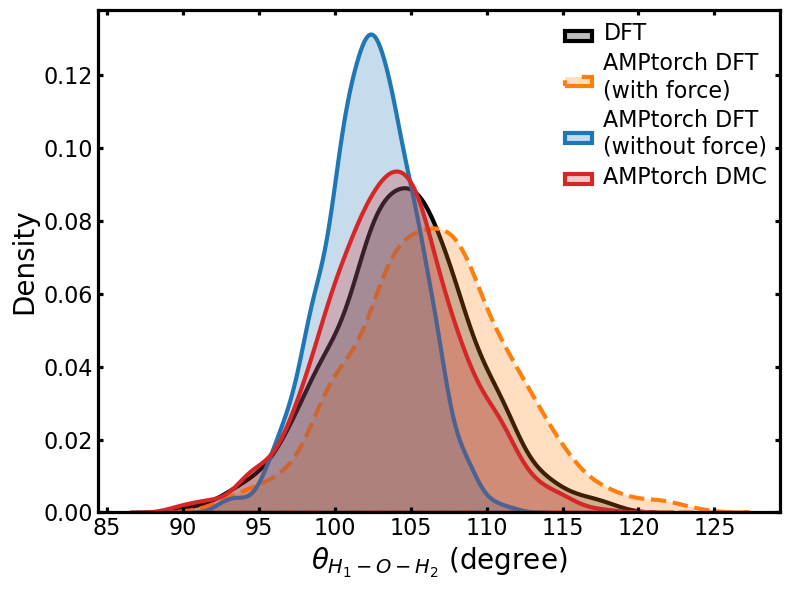

In [57]:
plot_data = {}
for item in file:
    plot_data[item] = data[item][r"$\theta_{H_{1}-O-H_{2}}$"]

figname = "h2o_nvt_theta_distribution.png"
xlabel = r"$\theta_{H_{1}-O-H_{2}}$ (degree)"
ylabel = "Density"

plt.style.use('default')
fig, ax = plt.subplots(figsize=(8,6))

for item in plot_data:
    if item == "AMPtorch DFT\n(with force)":
        sns.kdeplot(plot_data[item], 
                    shade = True, 
                    linewidth = 3, 
                    bw_adjust = 1, 
                    linestyle="dashed",
                    label = item, 
                    color = color[item],
                )
    else:
        sns.kdeplot(plot_data[item], 
                    shade = True, 
                    linewidth = 3, 
                    bw_adjust = 1, 
                    label = item, 
                    color = color[item],
                )

ax.set_xlabel(xlabel=xlabel)
ax.set_ylabel(ylabel=ylabel)
ax.tick_params(axis="y")
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.legend(frameon=False)
useLargeSize(plt, ax)
plt.savefig("./nvt/{}".format(figname), dpi=300)